# Run Camera Calibration to Remove Effect of MTF

The Camera System including lens, sensor, and early pipeline processing does not necessarily have an equal effect on all spatial frequencies - some could be more dampened more than others and some could be boosted. Given that the Spatiotemporal Power Spectrum measure The Modulation Transfer Function describes this effect

## Dependencies

In [1]:
import os, stat
import numpy as np
import msgpack
import cv2
import matplotlib.pyplot as plt
import utils.traceconvert as traceconvert
import random
import glob
import yaml
import math
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (8.0, 5.0)
import utils.bins_to_pngs as bin2png
import stftoolkit as stf

## Parameters

*** NOTE: REALLY NEED TO CHECK ON THE VALUES FOR HORIZONTAL AND VERTICAL FOV ***

In [2]:
base_dir = '/hmet_data/full_collection_dec2020/'
trial_num = '000'
data_dir = os.path.join(base_dir, 'raw', '2020_12_22', trial_num)
#output_dir = os.path.join(base_dir, 'analysis', 'mtf', trial_num)
#output_dir = os.path.join(base_dir, 'analysis')
#output_dir = './output/matched_frames'

###DEFINITELY NEED TO CHECK ON THESE VALUES
horizontal_fov_deg = 61
#vertical_fov_deg = 61

img_dims=(1544,2064)
save_batchsize = 400

reconvert=False

## Specify Directories for Exmaple

In [3]:
example_trial = 'mtf'
iteration = trial_num
#trial_directory = os.path.join(data_dir, example_subject, iteration)
pngs_dir = os.path.join(base_dir, 'pngs', example_trial, iteration)
save_dir = os.path.join('./output', example_trial, iteration)

try:
    os.makedirs(save_dir)
    os.makedirs(pngs_dir)
except:
    print(f'{save_dir} already made!')

#analysis_folder = os.path.join(output_dir, example_trial, example_subject, iteration)
#common_timeline_file = os.path.join(analysis_folder,'common_timeline.npy')
#pupil_positions_file = os.path.join(trial_directory, 'eye_camera','000','exports','000','pupil_positions.csv')

#three trace conditions: true, none, temporal_match, spatial_match 
#trace_type='fixation_eye_0
#trace_type='none'


./output/mtf/000 already made!


## Convert Frames to PNGS

In [4]:
binfilename = os.path.join(data_dir,'ximea','ximea',f'frames_0_{save_batchsize-1}.bin')
first_fnum = 0
if(reconvert):
    bin2png.convert_bin_pngs(binfilename, first_fnum, save_batchsize, pngs_dir)
else:
    print('Skipping conversion step!')

Skipping conversion step!


## Read in Imaged Star

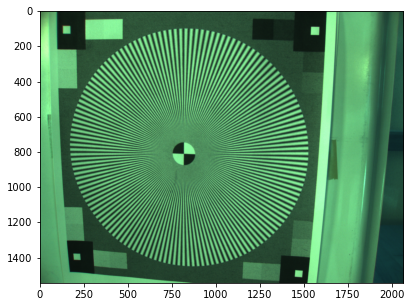

In [5]:
i=30
star_frame = cv2.imread(os.path.join(pngs_dir, f'frame_{i}.png'))
plt.imshow(star_frame)

## Remove Image Warping
Read in Camera Matrix and Distortion Matrix as measured with checkerboard pattern to remove camera distortion

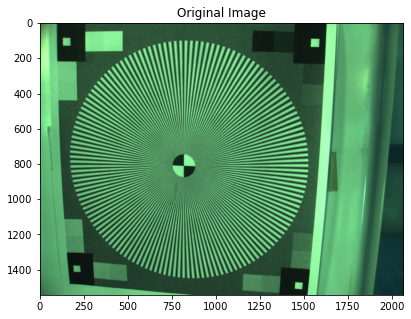

Text(0.5, 1.0, 'Undistorted Image')

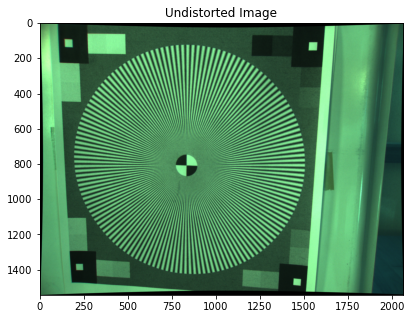

In [6]:
calibration_fname = os.path.join('/','hmet_data','calibration', 'analysis',"calibration_ximea_distortion.yaml")

with open(calibration_fname) as f:
    loadeddict = yaml.load(f, Loader=yaml.BaseLoader)
mtx = np.asarray(loadeddict.get('camera_matrix'), dtype='float32')
dist = np.asarray(loadeddict.get('dist_coeff'), dtype='float32')

h, w = star_frame.shape[:2]
newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))

star_frame_undistorted = cv2.undistort(star_frame, mtx, dist, None, newcameramtx)
plt.imshow(star_frame)
plt.title('Original Image')
plt.show()
plt.imshow(star_frame_undistorted)
plt.title('Undistorted Image')

## Simple White Balance
I'm not sure if this is strictly necessary for the alignment and subsequent processing but I really don't want to look at this green/yellow image

Lowval:  0
Highval:  158
Lowval:  0
Highval:  254
Lowval:  0
Highval:  170


Text(0.5, 1.0, 'White Balanced Star Frame')

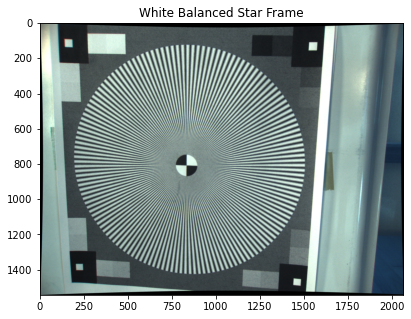

In [7]:
#from https://gist.github.com/DavidYKay/9dad6c4ab0d8d7dbf3dc

def apply_mask(matrix, mask, fill_value):
    masked = np.ma.array(matrix, mask=mask, fill_value=fill_value)
    return masked.filled()

def apply_threshold(matrix, low_value, high_value):
    low_mask = matrix < low_value
    matrix = apply_mask(matrix, low_mask, low_value)

    high_mask = matrix > high_value
    matrix = apply_mask(matrix, high_mask, high_value)

    return matrix

def simplest_cb(img, percent):
    assert img.shape[2] == 3
    assert percent > 0 and percent < 100

    half_percent = percent / 200.0

    channels = cv2.split(img)

    out_channels = []
    for channel in channels:
        assert len(channel.shape) == 2
        # find the low and high precentile values (based on the input percentile)
        height, width = channel.shape
        vec_size = width * height
        flat = channel.reshape(vec_size)

        assert len(flat.shape) == 1

        flat = np.sort(flat)

        n_cols = flat.shape[0]

        low_val  = flat[math.floor(n_cols * half_percent)]
        high_val = flat[math.ceil( n_cols * (1.0 - half_percent))]

        print("Lowval: ", low_val)
        print("Highval: ", high_val)

        # saturate below the low percentile and above the high percentile
        thresholded = apply_threshold(channel, low_val, high_val)
        # scale the channel
        normalized = cv2.normalize(thresholded, thresholded.copy(), 0, 255, cv2.NORM_MINMAX)
        out_channels.append(normalized)

    return cv2.merge(out_channels)

wb_star_frame_undistorted = simplest_cb(star_frame_undistorted, 3)
plt.imshow(wb_star_frame_undistorted)
plt.title('White Balanced Star Frame')

Ok this is much less annoying to look at! Unclear though if this is really the correct algorithm.

## Take mean to make Image Greyscale
Do this for both the white balanced and the original images

Text(0.5, 1.0, 'White Balanced Star Frame - Greyscale')

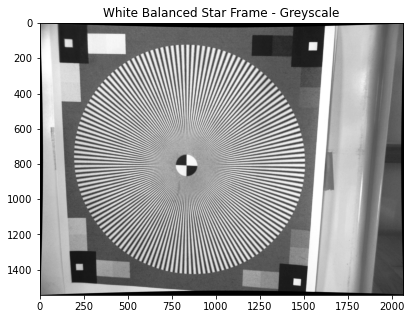

In [8]:
plt.imshow(np.mean(wb_star_frame_undistorted,axis=-1),cmap='Greys_r')
plt.title('White Balanced Star Frame - Greyscale')

Text(0.5, 1.0, 'Star Frame - Greyscale')

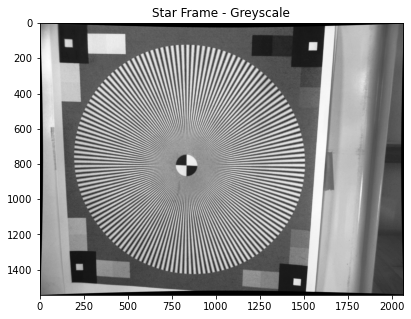

In [9]:
star_frame_grey = np.mean(star_frame_undistorted,axis=-1)
plt.imshow(star_frame_grey,cmap='Greys_r')
plt.title('Star Frame - Greyscale')

## Read in Original Star Image

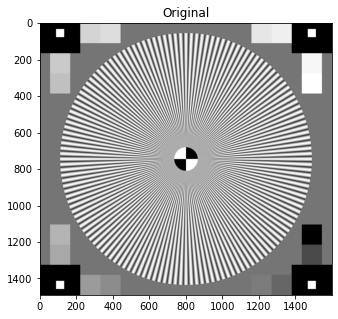

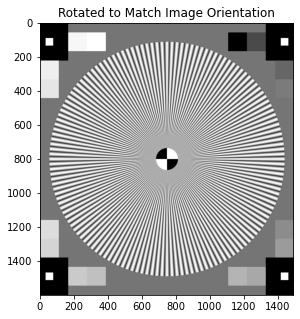

In [10]:
star_img = cv2.imread('./starpattern.png')
plt.imshow(star_img)
plt.title('Original')
plt.show()
star_img = np.rot90(star_img)
plt.imshow(star_img)
plt.title('Rotated to Match Image Orientation')
plt.show()

## Detect ROIs to Match Imaged and Original Stars

In [11]:
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(wb_star_frame_undistorted,None)
kp2, des2 = sift.detectAndCompute(star_img,None)

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 15) #5 default
search_params = dict(checks=1000)

flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

good = []
pts1 = []
pts2 = []

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.5*n.distance:
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv2.findFundamentalMat(pts1,pts2)
#G, mask = cv2.getAffineTransform(pts1,pts2)
H = cv2.findHomography(pts1, pts2)

# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]
star_frame_points = wb_star_frame_undistorted.copy()
star_img_points = star_img.copy()

(<AxesSubplot:title={'center':'Star Image (Ground Truth)'}>,
 Text(0.5, 1.0, 'Star Image (Ground Truth)'))

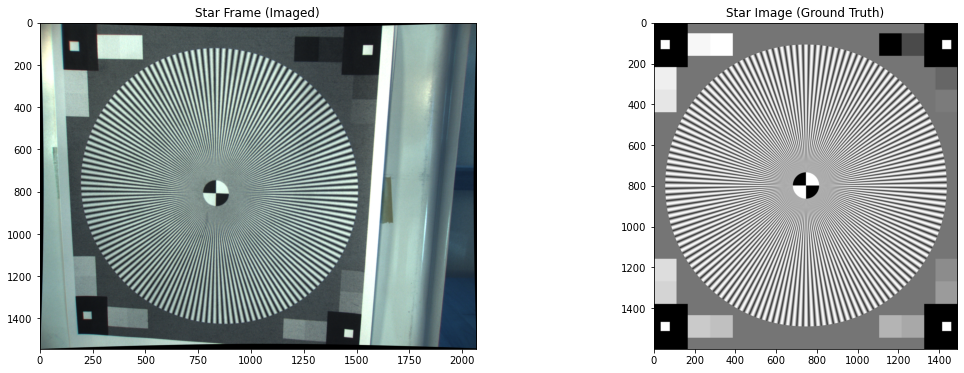

In [12]:
def drawpoints(img1,img2,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
    '''
    r,c,_ = img1.shape
    for pt1,pt2 in zip(pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        img1 = cv2.circle(img1.copy(),tuple(pt1),20,color,-1)
        img2 = cv2.circle(img2.copy(),tuple(pt2),20,color,-1)
    return img1,img2
img5,img6=drawpoints(wb_star_frame_undistorted, star_img, pts1, pts2)
plt.close()
plt.figure(figsize=(18,6))
plt.subplot(121),plt.imshow(img5),plt.title('Star Frame (Imaged)')
plt.subplot(122),plt.imshow(img6),plt.title('Star Image (Ground Truth)')

## Warp Imaged Star to Match Original Target

(<AxesSubplot:title={'center':'Original Star Image'}>,
 Text(0.5, 1.0, 'Original Star Image'))

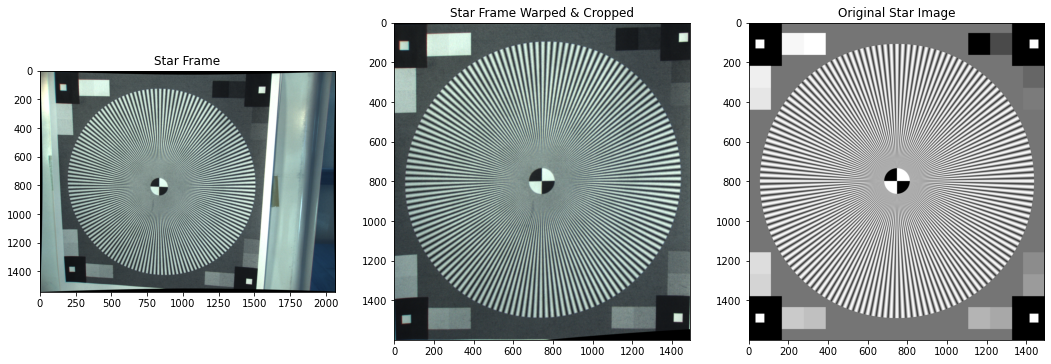

In [13]:
star_transformed = cv2.warpPerspective(wb_star_frame_undistorted, H[0], np.shape(star_img)[:2][::-1])
#star_transformed = star_transformed[:star_img.shape[0],:star_img.shape[1],:] #crop
plt.figure(figsize=(18,6))
plt.subplot(131),plt.imshow(wb_star_frame_undistorted),plt.title('Star Frame')
plt.subplot(132),plt.imshow(star_transformed),plt.title('Star Frame Warped & Cropped')
plt.subplot(133),plt.imshow(star_img),plt.title('Original Star Image')


So this finally worked pretty well, by hand-adjusting the distance value. I'm not at all confident this method would be robust if this calibration is done multiple times in different lighting conditions (every time we adjust the aperature).  

A more robust way to do this would be to detect the corners of the target and warp based on those, rather than the points chosen by SIFT Not sure exactly how to do that however. Could also try an alternative algorithm to SIFT.  

For now, let's build up the rest of the pipeline and revisit this if/when we need to.  

## Ensure Distributions Match

Text(0.5, 1.0, 'Pre Normalization')

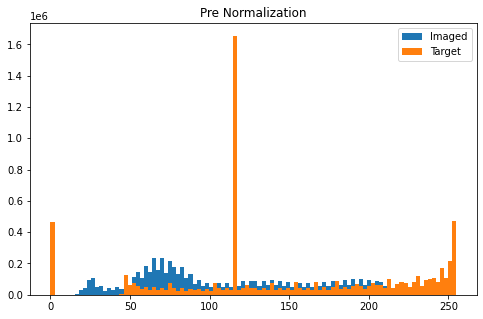

In [14]:
plt.hist(star_transformed.flatten(), bins=100, label='Imaged');
plt.hist(star_img.flatten(), bins=100, label='Target');
plt.legend()
plt.title('Pre Normalization')

Text(0.5, 1.0, 'Post Normalization')

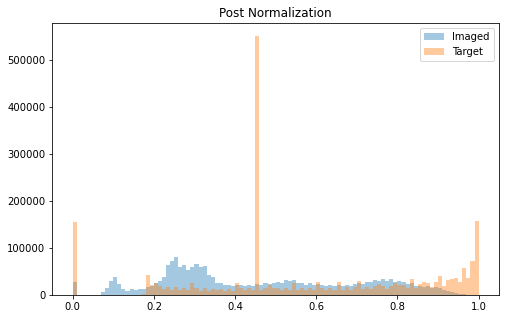

In [26]:
def scale_norm_grey(img):
    img = np.mean(img,axis=-1) #MAKE GREYSCALE
    img = img - np.min(img) #SET MIN TO ZERO
    img = img/np.max(img) #MAX 1
    return(img)
    
imaged = scale_norm_grey(star_transformed)
target = scale_norm_grey(star_img)
plt.hist(imaged.flatten(), bins=100, label='Imaged', alpha=0.4);
plt.hist(target.flatten(), bins=100, label='Target', alpha=0.4);
plt.legend()
plt.title('Post Normalization')

(<AxesSubplot:title={'center':'Target'}>,
 Text(0.5, 1.0, 'Target'))

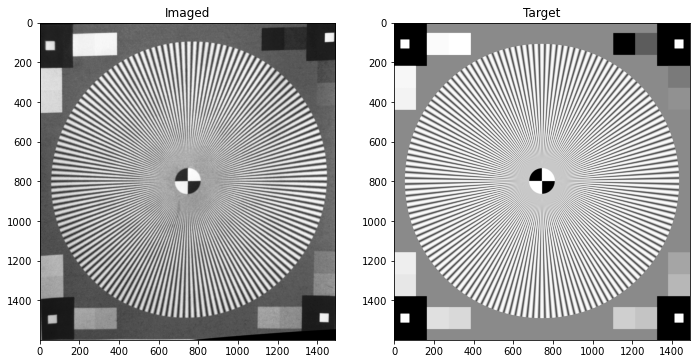

In [16]:
plt.figure(figsize=(18,6))
plt.subplot(131),plt.imshow(imaged,cmap='Greys_r'),plt.title('Imaged')
plt.subplot(132),plt.imshow(target,cmap='Greys_r'),plt.title('Target')

## Compare FFTs of Original and Imaged Stars

In [17]:
def spatialft(image, cosine_window=True, rmdc=True, power=True):
    """Take the fourier transform of an image (or flow field).
    shift the quadrants around so that low spatial frequencies are in
    the center of the 2D fourier transformed image"""

    #remove color dimension
    if(image.ndim >2):
        image = np.mean(image,axis=-1)
    
    #raised cosyne window on image to avoid border artifacts
    (dim1,dim2) = np.shape(image)
    if(cosine_window):
        cosfilter = np.tile(np.hanning(dim2), (dim1,1))*(np.tile(np.hanning(dim1), (dim2,1)).T)
        image = image * cosfilter
    
    # remove DC component
    if(rmdc):
        image =  image - np.mean(image)
    
    spec = np.fft.fftshift(np.fft.fft2(image))
    fqs = [np.fft.fftshift(np.fft.fftfreq(np.shape(image)[0])),
           np.fft.fftshift(np.fft.fftfreq(np.shape(image)[1]))]

    if power:
        return(np.abs(spec)**2, fqs)
    else:
        return(spec, fqs)

In [18]:
star_target_ps, fqs = spatialft(target, cosine_window=False)
star_imaged_ps, fqs = spatialft(imaged, cosine_window=False)

(<AxesSubplot:title={'center':'Imaged Power Spec'}>,
 Text(0.5, 1.0, 'Imaged Power Spec'))

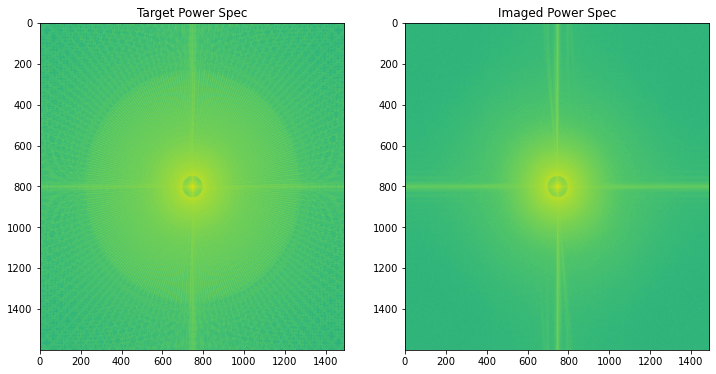

In [19]:
plt.figure(figsize=(12,8))
plt.subplot(121),plt.imshow(np.log10(star_target_ps)),plt.title('Target Power Spec')
plt.subplot(122),plt.imshow(np.log10(star_imaged_ps)),plt.title('Imaged Power Spec')


## Infer MTF by Convolution Theorm

(<AxesSubplot:title={'center':'PSF'}>,
 Text(0.5, 1.0, 'PSF'))

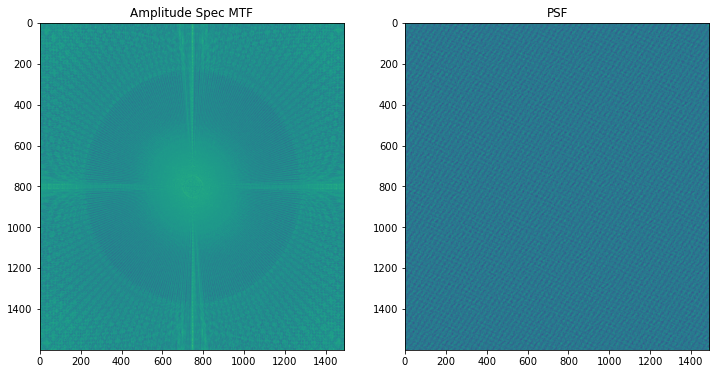

In [21]:
star_target_ft, fqs = spatialft(target, cosine_window=False, power=False)
star_imaged_ft, fqs = spatialft(imaged, cosine_window=False, power=False)

mtf2d = star_imaged_ft / star_target_ft
psf2d = np.real(np.fft.ifft2(np.fft.ifftshift(mtf2d)))

plt.figure(figsize=(12,8))
plt.subplot(121),plt.imshow(np.log10(np.abs(mtf2d))),plt.title('Amplitude Spec MTF')
plt.subplot(122),plt.imshow(psf2d),plt.title('PSF')


# Collapse to 1D - Power Spectrum

Need to average over power spectra (not amplitude or FT directly - but thyen how can we invert and get MTF?)

In [27]:
2064/2/61

16.918032786885245

In [22]:
#fqs are in cycles per image, convert to cycles per degree
# cycles per image (longest dim)
#ximea speec params
img_dims = (1544,2064)
horizontal_fov_deg = 61.
horiz_ppd = img_dims[1]/horizontal_fov_deg

Text(0.5, 1.0, 'Azimuthal Averaged Power Spectra')

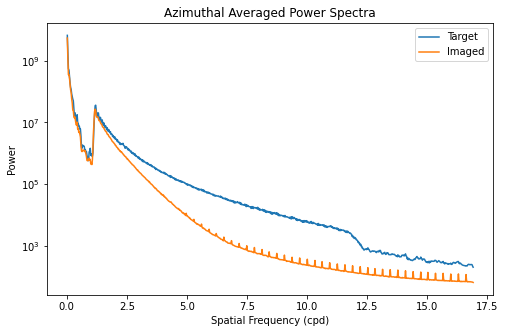

In [23]:
# plt.imshow(np.log(star_img_ps - star_transformed_ps + 0.0001))
# plt.title('Difference')
# plt.colorbar()
star_target_ps_avg, fqs1d_cpp = stf.azimuthalAverage(star_target_ps, 0.5, bin_in_log=False)
star_imaged_ps_avg, fqs1d_cpp = stf.azimuthalAverage(star_imaged_ps, 0.5, bin_in_log=False)

fqs_cpd = fqs1d_cpp * horiz_ppd

plt.plot(fqs_cpd, star_target_ps_avg,label='Target')
plt.plot(fqs_cpd, star_imaged_ps_avg,label='Imaged')
plt.semilogy()
plt.xlabel('Spatial Frequency (cpd)')
plt.ylabel('Power')
plt.legend()
plt.title('Azimuthal Averaged Power Spectra')


## Infer MTF by Convolution Theorm

This is not currently Acutally the MTF because it the the ratio of the power spectra, not the FTs.

Text(0.5, 1.0, 'Calculated Modulation Transfer Function')

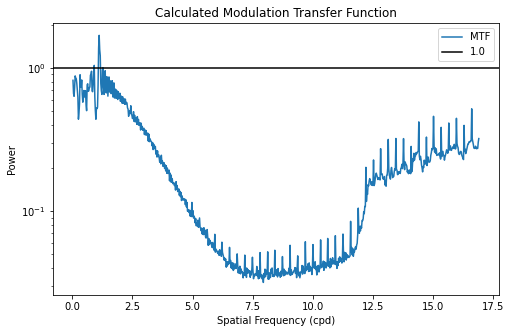

In [24]:
star_target_ft, fqs = spatialft(target, cosine_window=False, power=False)
star_imaged_ft, fqs = spatialft(imaged, cosine_window=False, power=False)

mtf = star_imaged_ps_avg / star_target_ps_avg
plt.plot(fqs_cpd, mtf, label='MTF')
plt.axhline(1.0, c='k', label='1.0')
plt.semilogy()
plt.xlabel('Spatial Frequency (cpd)')
plt.ylabel('Power')
plt.legend()
plt.title('Calculated Modulation Transfer Function')

In [ ]:
{}